### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 3
### Due: Saturday, Feb 12th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*

5) Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [7]:
!pip install numdifftools

In [8]:
import numdifftools as nd
H = nd.Hessian(f_lnlaplace)([beta_laplace[0], beta_laplace[1]])
sigma_laplace = np.linalg.inv(H)**0.5

NameError: name 'f_lnlaplace' is not defined

### Solution

In [29]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats
from scipy.stats import norm
from scipy import optimize

In [28]:
# (1) Read in hw3_data_1.npy. This is a (50 x 2) numpy array, with measurements in the first column and 
# uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, 
# compute the sample mean and the standard error on the sample mean from for this data.

data = np.load("../../homeworks/hw_data/hw3_data_1.npy") 
meas = np.array([i[0] for i in data])
uncert = np.array([i[1] for i in data])
# calculating sample mean and error from derivation in Lecture 5
sample_mu = np.sum(meas/uncert**2)/np.sum(1/uncert**2)
error = np.sum(1/uncert**2)**(-1/2)
print('sample mean: ',sample_mu)
print('standard error:',error)

sample mean:  3.9179920346060557
standard error: 0.09481084100510954


In [49]:
# (2) Reusing some approaches and tools from Lecture_6, write a ln-likelihood function for heteroscedastic 
# Gaussian data, and use it in a fitting algorithm to find the best-fit mean. Remember that scipy optimizers are 
# set up to minimize functions.

# chi^2 = sum(((xi-mu)/sigma)^2)...ln-likelihood is chi^2 for gaussian
def squared_loss(m, b, x, y, dy):
    y_fit = m * x + b
    return np.sum(((y - y_fit) / dy) ** 2, -1)

# sample_mu_arr = np.full(shape=len(meas),fill_value=sample_mu)
f_squared = lambda beta: squared_loss(beta[0], beta[1], 
                                      x=sample_mu, y=meas, 
                                      dy=uncert)

#------------------------------------------------------------
# compute the maximum likelihood 
beta0 = (1, 30) # initial guess for a and b
beta_squared = optimize.fmin(f_squared, beta0)

beta_squared[0] * sample_mu + beta_squared[1]

Optimization terminated successfully.
         Current function value: 86.325091
         Iterations: 64
         Function evaluations: 125


3.9179920414003684

In [50]:
# (3) Using the same numerical technique from Lecture_5, compute the Fisher uncertainty estimate on the mean.
error/np.sqrt(len(meas))

0.009481084100510954

In [134]:
# (4) Using the bootstrap method, generate  1000  bootstrap realizations of this dataset. DO NOT use the astroML code. 
# Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and 
# uncertainties should stay paired together.

import random
from random import choices

def bootsp(mean,sigma,resample=1000):
    length = len(mean)
    mean_array,sigma_array = [],[]
    for i in range(resample):
        # sampling indices so that measurements & uncertainties stay paired together
        idxs = choices(np.arange(0,length,1),k=length)
        sample_mean = mean[idxs] #choices(mean,k=length)
        sample_sigma = sigma[idxs]#choices(sigma,k=length)
        mu_val = np.mean(sample_mean)
        sig_val = np.mean(sample_sigma)
        mean_array.append(mu_val)
        sigma_array.append(sig_val)
    boot_mean = np.mean(mean_array)
    boot_sigma = np.std(sigma_array)
    return mean_array,sigma_array,boot_mean,boot_sigma

# print('bootstrap mean: ',bootsp(meas,uncert)[0])
# print('bootstrap sigma: ',bootsp(meas,uncert)[1])

In [124]:
colors = ["R", "G", "B", "Y"]
choices(colors,k=4)
np.random.choice(colors,size=4, replace=True)

array(['Y', 'G', 'B', 'R'], dtype='<U1')

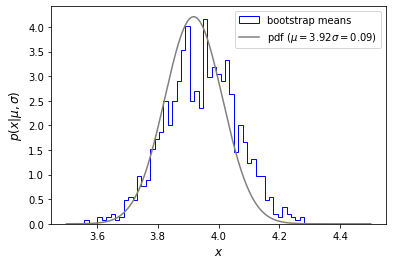

In [152]:
# (5) Repeat (2) with all  1000  boostrap datasets to find the distribution of the sample mean. Plot a normalized 
# histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?
bootstrap_means = bootsp(meas,uncert)[0]
x = np.linspace(3.5, 4.5, 1000)
dist = scipy.stats.norm(sample_mu,error)
plt.hist(bootstrap_means,bins=50,density=True,histtype='step',color='b',label='bootstrap means')
plt.plot(x,dist.pdf(x),c='gray',label=r'pdf ($\mu=$'+str(round(sample_mu,2))+r'$\sigma=$'+str(round(error,2))+')')
plt.xlabel(r'$x$',fontsize=12)
plt.ylabel(r'$p(x|\mu,\sigma)$',fontsize=12)
plt.legend(loc='upper right')
plt.show()

In [ ]:
# (6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to 
# define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace 
# location parameter 𝜇 and scale parameter Δ
